In [ ]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from joblib import dump, load
import shap

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import r2_score, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

# Настройка видимости строк и столбцов
pd.set_option('display.max_rows', 50)  # Показать все строки
pd.set_option('display.max_columns', 20)  # Показать все столбцы
pd.set_option('display.width', None)  # Автоматически подбирать ширину
pd.set_option('display.max_colwidth', None)  # Показать полное содержимое ячеек

pd.set_option('display.float_format', '{:.2f}'.format)  # Убрать в выводе экспоненциальную запись

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 11.2 MB/s eta 0:00:00


In [ ]:
# path for colab
# train_path = '/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/train.csv'
# weather_path = '/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/weather.csv'
# weather_filtered_path = '/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/cash/weather_filtered.csv'
# key_path = '/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/key.csv'
# clear_train_path ='/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/cash/clear_train.csv'
# merged_train_path = '/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/cash/merged_train.csv'
# 
# X_train_path = '/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/cash/X_train.csv'
# X_test_path = '/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/cash/X_test.csv'
# y_train_path = '/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/cash/y_train.csv'
# y_test_path = '/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/cash/y_test.csv'

# path for local

from pathlib import Path
file_path = Path.cwd() # определение локального пути к проекту

train_path = file_path / '../data/00_raw/train.csv'
weather_path = file_path / '../data/00_raw/weather.csv'
key_path = file_path / '../data/00_raw/key.csv'

weather_filtered_path = file_path / '../data/01_intermediate/weather_filtered.csv'
clear_train_path = file_path / '../data/01_intermediate/clear_train.csv'
merged_train_path = file_path / '../data/01_intermediate/merged_train.csv'
filtered_units_path = file_path / '../data/01_intermediate/filtered_units.csv'

X_train_path = file_path / '../data/02_processed/X_train.csv'
X_test_path = file_path / '../data/02_processed/X_test.csv'
y_train_path = file_path / '../data/02_processed/y_train.csv'
y_test_path = file_path / '../data/02_processed/y_test.csv'


In [4]:
train = pd.read_csv(train_path, dtype={
    'store_nbr':'int16',  'item_nbr':'int16',  'units':'int16'
})

In [5]:
train['date'] = pd.to_datetime(train['date'] )

In [6]:
# Выведем основную информацию
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4617600 entries, 0 to 4617599
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   date       datetime64[ns]
 1   store_nbr  int16         
 2   item_nbr   int16         
 3   units      int16         
dtypes: datetime64[ns](1), int16(3)
memory usage: 61.7 MB


In [7]:
# Проверим датасет на наличие пропусков
train.isna().sum()

,0
date,0
store_nbr,0
item_nbr,0
units,0


Пропущенные значения в train отсутствуют.

In [8]:
train.head(10)

,date,store_nbr,item_nbr,units
0,2012-01-01,1,1,0
1,2012-01-01,1,2,0
2,2012-01-01,1,3,0
3,2012-01-01,1,4,0
4,2012-01-01,1,5,0
5,2012-01-01,1,6,0
6,2012-01-01,1,7,0
7,2012-01-01,1,8,0
8,2012-01-01,1,9,29
9,2012-01-01,1,10,0


In [9]:
# Выведем основные описательные статистики
train.describe()

,date,store_nbr,item_nbr,units
count,4617600,4617600.00,4617600.00,4617600.00
mean,2013-05-08 06:23:03.230769920,23.09,56.00,0.99
min,2012-01-01 00:00:00,1.00,1.00,0.00
25%,2012-08-22 00:00:00,12.00,28.00,0.00
50%,2013-04-15 00:00:00,23.00,56.00,0.00
75%,2014-01-24 00:00:00,34.00,84.00,0.00
max,2014-10-31 00:00:00,45.00,111.00,5568.00
std,NaN,12.95,32.04,9.88


**Размер датасета**: `4,617,600` строк
**Целевая переменная**: `units` — количество проданных единиц товара

**Магазины (store_nbr)**

* Всего **45 магазинов** (от `1` до `45`)
* Распределение равномерное: среднее ≈ `23`, стандартное отклонение ≈ `13`

**Товары (item_nbr)**

* Товаров всего **111 уникальных** (от `1` до `111`)
* Средний товар — `item_nbr = 56`, нормальное распределение

**Продажи (units)**

* **Среднее**: `0.99` — очень низкие продажи в среднем
* **Медиана (50%)**: `0.0` — половина наблюдений вообще без продаж
* **Максимум**: `5568` — есть редкие пики массовых продаж
* **Стандартное отклонение**: `9.88` — высокая дисперсия
* **75% квантиль**: `0.0` — значит, более 75% наблюдений имеют 0 продаж

**Это сильно разреженный датасет**.

In [10]:
# Загрузим датасет с погодой
weather = pd.read_csv(weather_path)

In [11]:
# Выведем основную информацию
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20517 entries, 0 to 20516
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   station_nbr  20517 non-null  int64 
 1   date         20517 non-null  object
 2   tmax         20517 non-null  object
 3   tmin         20517 non-null  object
 4   tavg         20517 non-null  object
 5   depart       20517 non-null  object
 6   dewpoint     20517 non-null  object
 7   wetbulb      20517 non-null  object
 8   heat         20517 non-null  object
 9   cool         20517 non-null  object
 10  sunrise      20517 non-null  object
 11  sunset       20517 non-null  object
 12  codesum      20517 non-null  object
 13  snowfall     20517 non-null  object
 14  preciptotal  20517 non-null  object
 15  stnpressure  20517 non-null  object
 16  sealevel     20517 non-null  object
 17  resultspeed  20517 non-null  object
 18  resultdir    20517 non-null  object
 19  avgspeed     20517 non-nu

In [12]:
# Выведем описательные статистики для типа данных object
weather.describe(include=[object])

,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
count,20517,20517,20517,20517,20517,20517,20517,20517,20517,20517,20517,20517,20517,20517,20517,20517,20517,20517,20517
unique,1035,121,108,112,66,99,93,77,37,219,223,449,77,285,322,153,249,37,254
top,2014-10-31,M,M,M,M,M,M,0,0,-,-,,0.0,0.00,M,M,M,17,M
freq,20,906,908,1469,11511,666,1252,9571,9833,9656,9656,11051,12683,11909,929,1724,589,1493,875


**Основные проблемы:**

1. **Строковые значения, как `"M"`, `"-"`, `"T"` и `"  T"`** встречаются в числовых признаках, но это невалидные данные:

   * `"M"` = пропущено, заменим на `np.nan`
   * `"T"` / `"  T"` = следовые осадки, заменим на `0.0`
   * `"-"` = неизвестно, также заменим на `np.nan`

2. Эти значения **искусственно повышают количество уникальных строковых категорий**, и мешают анализу.

3. `codesum` содержит **сотни уникальных сочетаний погодных условий** (например, `"RA SN FG"` = дождь, снег, туман). Эти коды следует удалить как мало неинформативныe.

4. Также приведем типы данных object к числовым. А date к `datetime`.

In [13]:
# Заменим "M", "-", "T", "  T" на np.nan или 0
weather.replace({"M": np.nan, "-": np.nan, "T": 0.0, "  T": 0.0}, inplace=True)

In [14]:
# Преобразуем 'date' в datetime
weather['date'] = pd.to_datetime(weather['date'], errors='coerce')

In [15]:
# Преобразуем все признаки (кроме station_nbr и date) в числовые
for col in weather.columns:
    if col not in ['station_nbr', 'date']:
        weather[col] = pd.to_numeric(weather[col], errors='coerce')

In [16]:
# Проверим корректность типов данных
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20517 entries, 0 to 20516
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station_nbr  20517 non-null  int64         
 1   date         20517 non-null  datetime64[ns]
 2   tmax         19611 non-null  float64       
 3   tmin         19609 non-null  float64       
 4   tavg         19048 non-null  float64       
 5   depart       9006 non-null   float64       
 6   dewpoint     19851 non-null  float64       
 7   wetbulb      19265 non-null  float64       
 8   heat         19048 non-null  float64       
 9   cool         19048 non-null  float64       
 10  sunrise      10861 non-null  float64       
 11  sunset       10861 non-null  float64       
 12  codesum      0 non-null      float64       
 13  snowfall     13293 non-null  float64       
 14  preciptotal  19657 non-null  float64       
 15  stnpressure  19588 non-null  float64       
 16  seal

In [17]:
weather = weather.drop(columns=['codesum'])

In [18]:
# Проверим пропущенные значения
missing_values = weather.isna().sum().sort_values(ascending=False)
missing_values

,0
depart,11511
sunrise,9656
sunset,9656
snowfall,7224
sealevel,1724
heat,1469
cool,1469
tavg,1469
wetbulb,1252
stnpressure,929


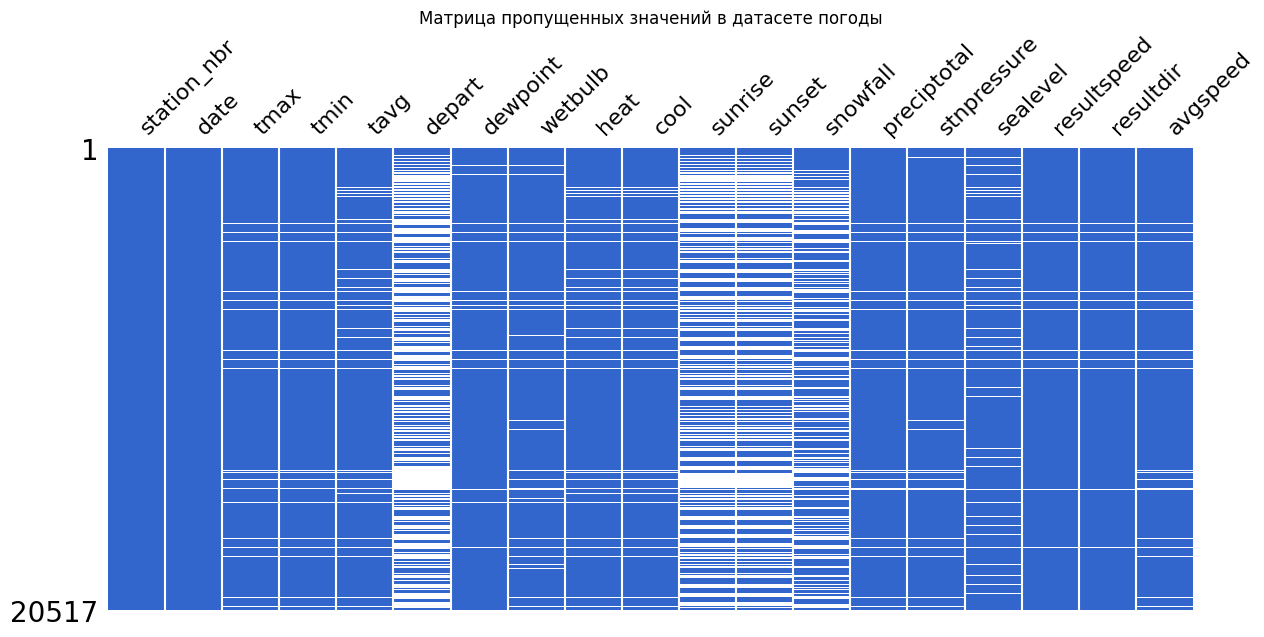

In [19]:
# Построим матрицу пропущенных значений
msno.matrix(weather, figsize=(14, 6), sparkline=False, color=(0.2, 0.4, 0.8))
plt.title("Матрица пропущенных значений в датасете погоды")
plt.show()

Столбцы `sunrise`, `sunset`, `depart` и `snowfall` имеют **сильно выраженные регулярные пропуски**, их стоит удалить.

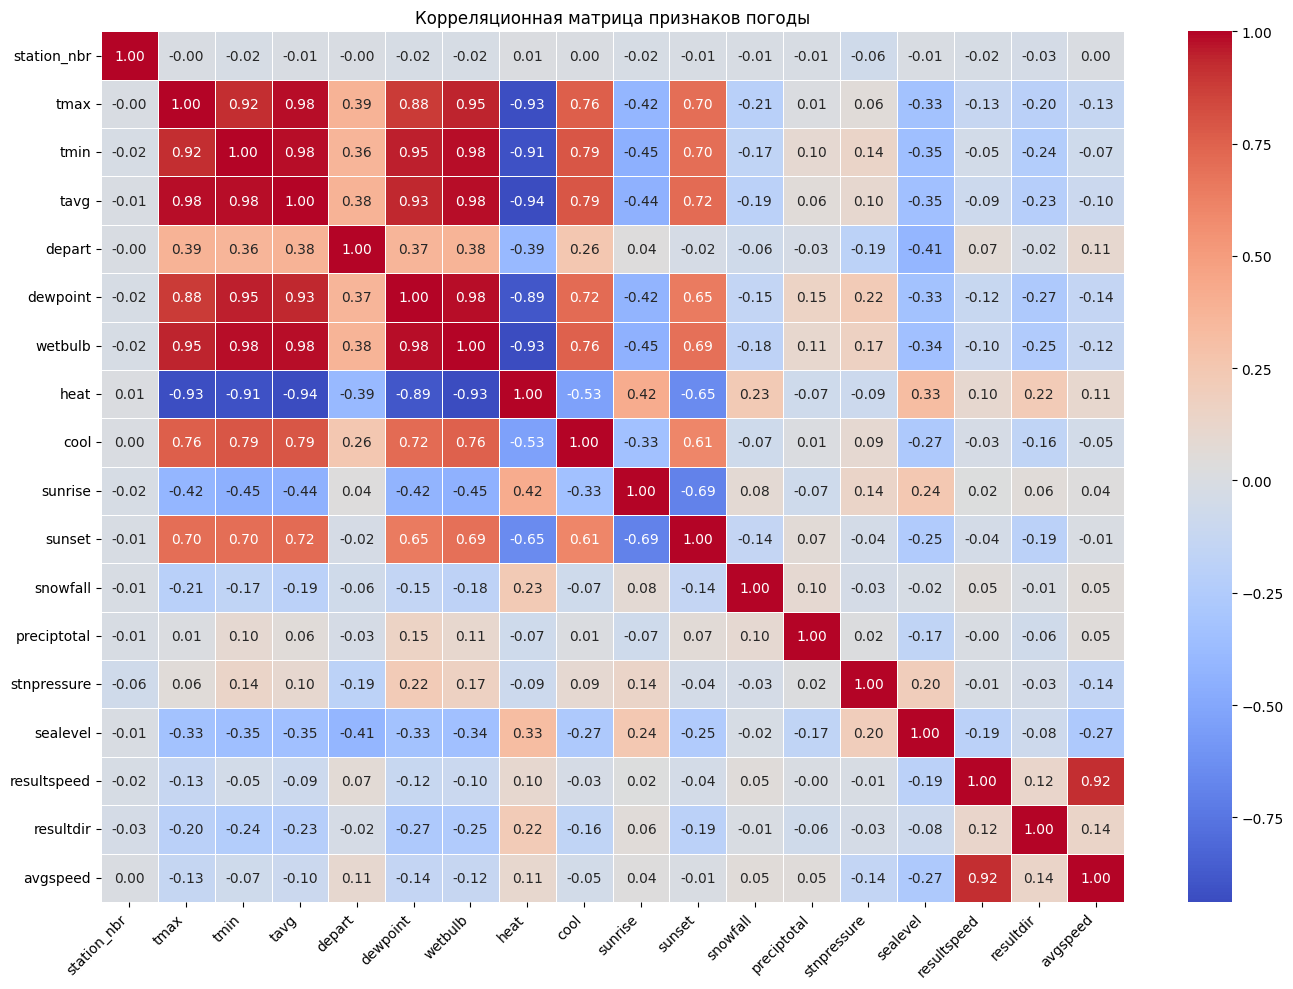

In [20]:
# Проведем корреляционный анализ
# Оставим только числовые признаки
numeric_weather = weather.select_dtypes(include=[np.number])

# Строим корреляционную матрицу
correlation_matrix = numeric_weather.corr()

# Визуализация — тепловая карта корреляций
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Корреляционная матрица признаков погоды")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Сильная положительная корреляция (ρ > 0.9)

| Признак 1  | Признак 2     | Коэффициент | Комментарий    |
| ---------- | ------------- | ----------- | -------------- |
| `tmax`     | `tavg`        | **0.98**    | температура    |
| `tmin`     | `tavg`        | **0.98**    | температура    |
| `tmax`     | `tmin`        | **0.92**    | температура    |
| `wetbulb`  | `dewpoint`    | **0.92**    | влажность      |
| `avgspeed` | `resultspeed` | **0.92**    | скорость ветра |

### Сильная отрицательная корреляция (ρ < -0.9)

| Признак 1 | Признак 2 | Коэффициент | Комментарий                                                |
| --------- | --------- | ----------- | ---------------------------------------------------------- |
| `heat`    | `tavg`    | **-0.93**   | закономерно: чем теплее, тем меньше потребность в обогреве |


Из каждой сильно коррелирующей группы оставить только один признак, чтобы избежать мультиколлинеарности.

#### Удалим признаки:

* `tmin`, `tmax`
* `wetbulb`, `dewpoint`
* `avgspeed`
* `sunrise`, `sunset` — слабые связи


In [21]:
weather['cool'].value_counts(normalize=True)

,proportion
cool,
0.00,0.52
18.00,0.02
16.00,0.02
17.00,0.02
14.00,0.02
8.00,0.02
7.00,0.02
4.00,0.02
15.00,0.02


In [22]:
weather['heat'].value_counts(normalize=True)

,proportion
heat,
0.00,0.50
1.00,0.02
2.00,0.02
8.00,0.02
7.00,0.02
...,...
66.00,0.00
72.00,0.00
71.00,0.00


Столбцы `heat` и `cool` имеют >50% нулей, в том числе после обработки значений `M`. Их также стоит удалить.

In [23]:
# Очищаем датасет от высокоскоррелированных признаков и признаков с большим количеством пропусков
weather_cropped = weather.drop(columns=['tmin', 'tmax', 'depart', 'wetbulb', 'dewpoint', 'sunrise', 'sunset', 'heat', 'cool', 'snowfall', 'avgspeed'])

In [24]:
# Повторно проверим итоговое состояние после очистки
weather_cropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20517 entries, 0 to 20516
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station_nbr  20517 non-null  int64         
 1   date         20517 non-null  datetime64[ns]
 2   tavg         19048 non-null  float64       
 3   preciptotal  19657 non-null  float64       
 4   stnpressure  19588 non-null  float64       
 5   sealevel     18793 non-null  float64       
 6   resultspeed  19928 non-null  float64       
 7   resultdir    19928 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 1.3 MB


In [25]:
weather_cropped.isna().sum().sort_values()

,0
station_nbr,0
date,0
resultspeed,589
resultdir,589
preciptotal,860
stnpressure,929
tavg,1469
sealevel,1724


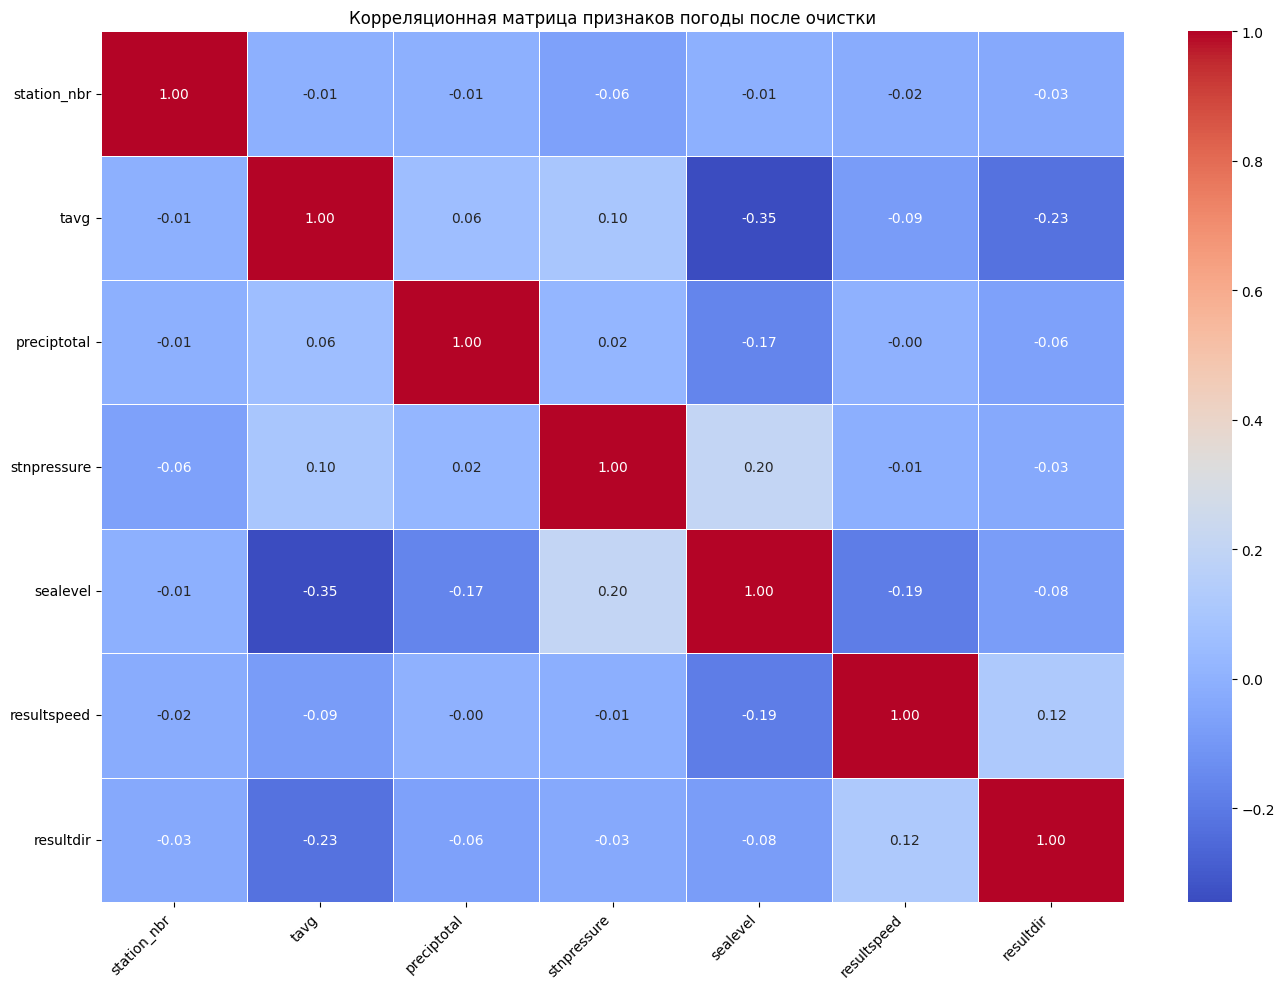

In [26]:
# Проведем повторный корреляционный анализ после очистки
# Оставим только числовые признаки
numeric_weather_cropped = weather_cropped.select_dtypes(include=[np.number])

# Строим корреляционную матрицу
correlation_matrix = numeric_weather_cropped.corr()

# Визуализация — тепловая карта корреляций
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Корреляционная матрица признаков погоды после очистки")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Теперь в датасете `weather_cropped` **отсутствуют высокоскоррелированные признаки**.

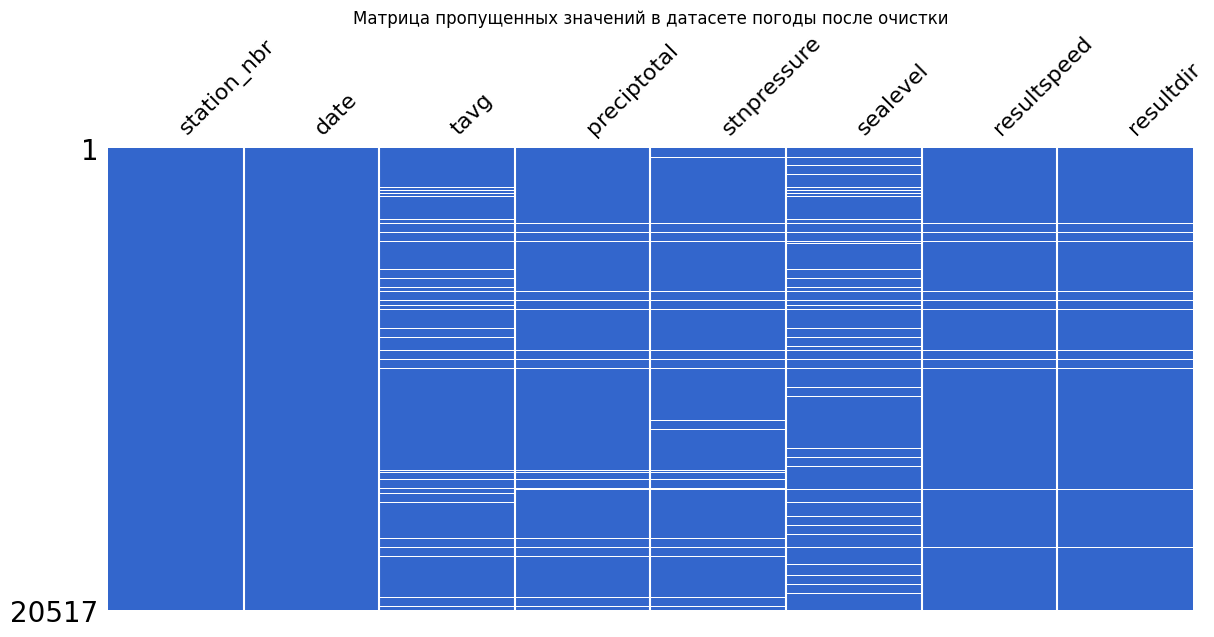

In [27]:
# Повторно построим матрицу пропущенных значений после очистки
msno.matrix(weather_cropped, figsize=(14, 6), sparkline=False, color=(0.2, 0.4, 0.8))
plt.title("Матрица пропущенных значений в датасете погоды после очистки")
plt.show()

**Определим, на какую станцию приходится больше всего пропусков.**

In [28]:
# I Вариант - определим, на какую станцию приходится больше всего пропусков
missing_tavg = weather_cropped[weather_cropped['tavg'].isna()]
print(missing_tavg['station_nbr'].value_counts())

station_nbr
5     822
8     468
7      41
9      19
13     14
16     13
2      12
4      10
10      8
19      8
20      7
3       7
14      6
6       6
1       6
15      5
17      5
11      4
12      4
18      4
Name: count, dtype: int64


In [29]:
# II Вариант - определим, на какую станцию приходится больше всего пропусков
missing_by_station = weather.groupby("station_nbr").apply(lambda df: df.isna().sum())
missing_by_station["total_missing"] = missing_by_station.sum(axis=1)
missing_by_station_sorted = missing_by_station.sort_values("total_missing", ascending=False)
missing_by_station_sorted.head(10)

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,total_missing
station_nbr,,,,,,,,,,,,,,,,,,,,
5,0,0,822,822,822,822,446,852,822,822,31,31,822,822,852,447,446,446,822,10949
8,0,0,14,12,468,1035,50,64,468,468,1035,1035,1030,5,10,1035,32,32,5,6798
9,0,0,6,7,19,1035,16,64,19,19,1035,1035,1017,5,6,14,3,3,5,4308
16,0,0,7,7,13,1035,8,11,13,13,1035,1035,1035,2,2,9,7,7,8,4247
1,0,0,2,2,6,1035,6,11,6,6,1035,1035,1035,5,4,8,4,4,3,4207
13,0,0,1,1,14,1035,0,3,14,14,1035,1035,1035,1,3,3,0,0,1,4195
7,0,0,35,34,41,1035,37,42,41,41,1035,1035,57,1,1,39,3,3,3,3483
20,0,0,2,4,7,1035,6,19,7,7,1035,1035,25,1,8,16,9,9,2,3227
17,0,0,1,1,5,1035,1,9,5,5,1035,1035,55,1,2,11,4,4,1,3210


**Итак, больше всего пропусков приходится на станцию 5. Удалим все такие строки, содержащие пропущенные значения.**

In [30]:
weather_filtered = weather_cropped[weather_cropped['station_nbr'] != 5]
display(weather_filtered.head())

,station_nbr,date,tavg,preciptotal,stnpressure,sealevel,resultspeed,resultdir
0,1,2012-01-01,42.00,0.05,29.78,29.92,3.60,20.00
1,2,2012-01-01,41.00,0.07,28.82,29.91,9.10,23.00
2,3,2012-01-01,45.00,0.00,29.77,30.47,9.90,31.00
3,4,2012-01-01,55.00,0.00,29.79,30.48,8.00,35.00
4,6,2012-01-01,49.00,0.00,29.95,30.47,14.00,36.00


In [31]:
weather_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19665 entries, 0 to 20516
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station_nbr  19665 non-null  int64         
 1   date         19665 non-null  datetime64[ns]
 2   tavg         19018 non-null  float64       
 3   preciptotal  19627 non-null  float64       
 4   stnpressure  19588 non-null  float64       
 5   sealevel     18388 non-null  float64       
 6   resultspeed  19522 non-null  float64       
 7   resultdir    19522 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 1.4 MB


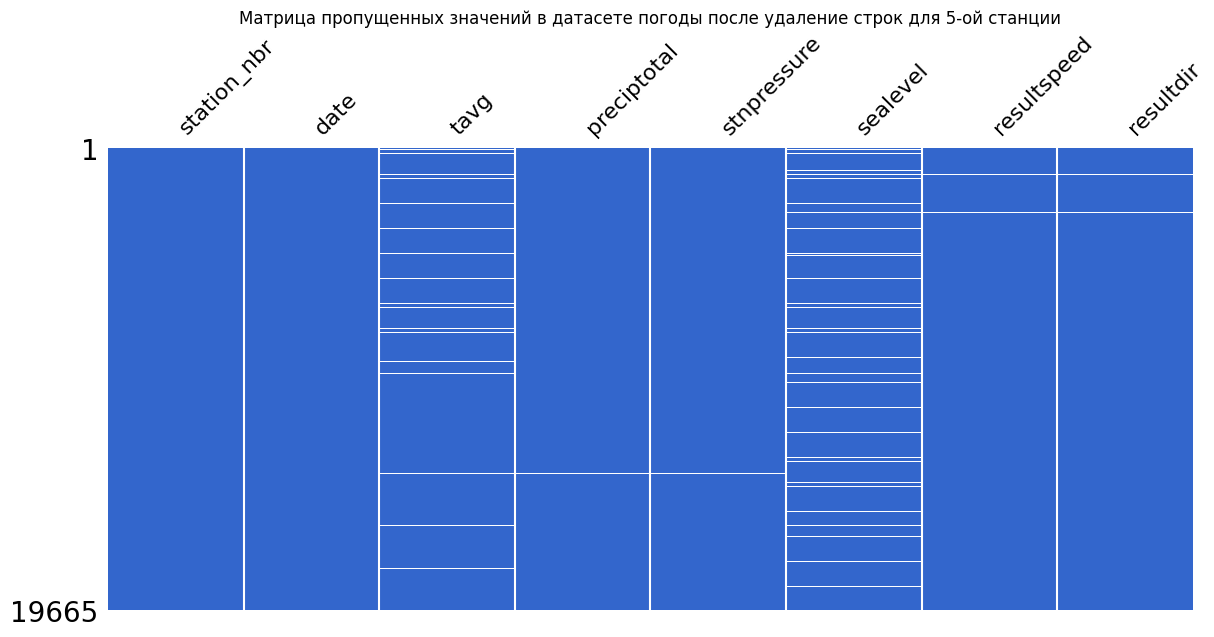

In [32]:
# Повторно построим матрицу пропущенных значений после удаление строк для 5-ой станции
msno.matrix(weather_filtered, figsize=(14, 6), sparkline=False, color=(0.2, 0.4, 0.8))
plt.title("Матрица пропущенных значений в датасете погоды после удаление строк для 5-ой станции")
plt.show()

**В итоге заметно, как остается совсем мало пропущенных значений, которые теперь можно обработать, заполнив теми или иными значениями.**

In [33]:
weather_filtered.to_csv(weather_filtered_path, index=False)

# Также очистим датасет от оставшихся пропусков, заполнив их значениями


In [34]:
# посмотрим есть ли зависимость у пропусков в фиче sealevel
# видим, что больше всего пропусков в sealevel для station_nbr == 8 (в 8 стации всегда пропущено sealevel)
print('максимум пропусков в sealevel по одной station_nbr(8) =', weather_filtered[weather_filtered.sealevel.isna()].station_nbr.value_counts().iloc[0],
      'всего пропусков в sealevel по всем station_nbr =',
      weather_filtered[weather_filtered.sealevel.isna()].station_nbr.value_counts().sum())

# так же и в tavg (но тут мы можем оработать пропуски средним значение)
print('максимум пропусков в tavg по одной station_nbr(8) =', weather_filtered[weather_filtered.tavg.isna()].station_nbr.value_counts().iloc[0],
      'всего пропусков в tavg по всем station_nbr =',
      weather_filtered[weather_filtered.tavg.isna()].station_nbr.value_counts().sum())

максимум пропусков в sealevel по одной station_nbr(8) = 1035 всего пропусков в sealevel по всем station_nbr = 1277
максимум пропусков в tavg по одной station_nbr(8) = 468 всего пропусков в tavg по всем station_nbr = 647


# Отработаем фичи sealevel и tavg. Добавим 'tavg_C' 'month' 'season' 'precip_mm'

- **tavg** оставим без изменений, а **tavg_C** пропуски заменим на среднее по станции и сезону
- **sealevel** пропуски также заменим на среднее, для 8 станции заменим на среднее значение для всех станций
- добавим сезоны и переведем давление в мм рт столба


In [35]:
def f_to_c(f):
    if pd.isna(f):
        return pd.NA
    return (f - 32) * 5.0/9.0

# переводим в celsium
weather_filtered['tavg_C'] = weather_filtered['tavg'].apply(f_to_c)

# Добавим столбец месяца и сезона
weather_filtered['month'] = pd.to_datetime(weather_filtered['date']).dt.month

# Определим сезоны: например, зимний (12,1,2), весенний (3-5), летний (6-8), осенний (9-11)
def get_season(m):
    if m in [12, 1, 2]: return 'winter'
    if m in [3, 4, 5]: return 'spring'
    if m in [6, 7, 8]: return 'summer'
    return 'autumn'

weather_filtered['season'] = weather_filtered['month'].apply(get_season)

# Переводим осадки из дюймов в мм (1 дюйм = 25.4 мм)
weather_filtered['precip_mm'] = weather_filtered['preciptotal'] * 25.4


In [36]:
# для station_nbr == 8 отдельно обработал
# не знаю почему - не менялось через дефолтные фильтры, поэтому написал через loc
keys_nan = weather_filtered[weather_filtered.station_nbr == 8].index
weather_filtered.loc[weather_filtered[weather_filtered.station_nbr == 8].index, 'sealevel'] = 30.015


# меняет sealevel
for i in range(1, 21) :
    if i == 8 :
        continue
    weather_filtered.loc[weather_filtered[(weather_filtered.station_nbr == i) & (weather_filtered.sealevel.isna())].index, 'sealevel'] =\
          weather_filtered.loc[weather_filtered[(weather_filtered.station_nbr == i)].index, 'sealevel'].mean(skipna=True)

# обработка пропусков в precip_mm и tavg_C
for col in ['precip_mm', 'tavg_C']:
# Сначала заполняем NaN средним по станции и сезону
    weather_filtered[col] = weather_filtered.groupby(['station_nbr', 'season'])[col] \
                                    .transform(lambda x: x.fillna(x.mean()))
    # Затем, если остались NaN (сезон полностью пуст), заполняем средним по станции
    weather_filtered[col] = weather_filtered.groupby('station_nbr')[col] \
                                .transform(lambda x: x.fillna(x.mean()))



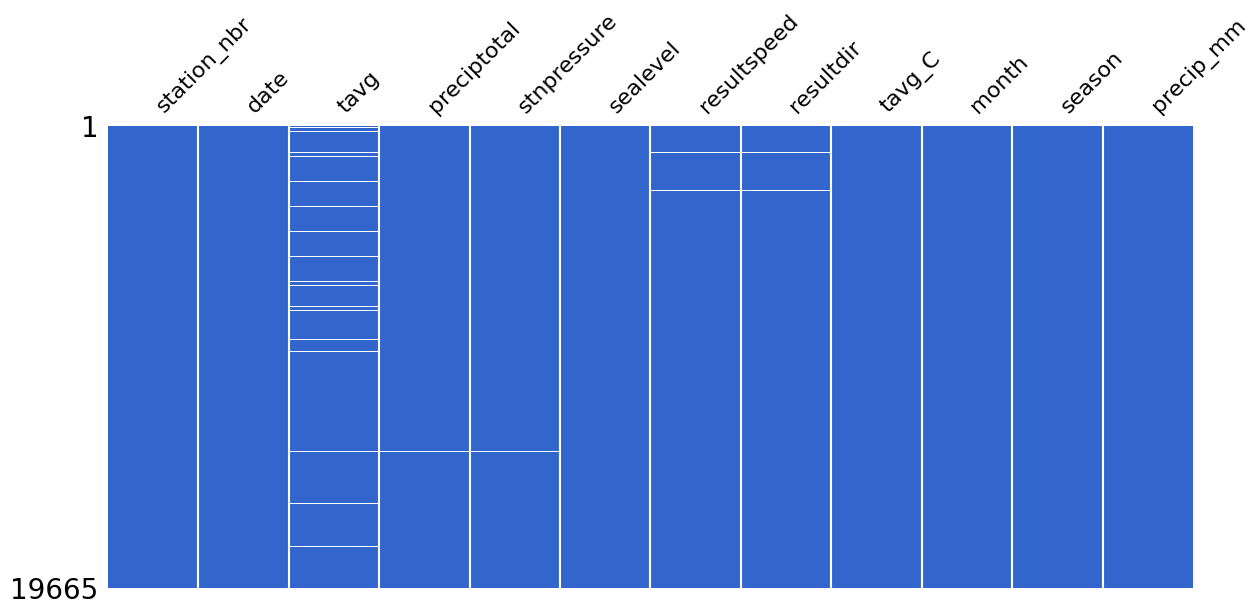

,count
station_nbr,


In [37]:
# проверим оставшиеся пропуски
msno.matrix(weather_filtered, figsize=(14, 6), sparkline=False, color=(0.2, 0.4, 0.8))
plt.show()
display(weather_filtered[weather_filtered.sealevel.isna()].station_nbr.value_counts())

# Заполним пропуски в остальных фичах средним по фичам и станции
stnpressure resultspeed resultdir

In [38]:
for col in ['resultspeed', 'resultdir', 'stnpressure']:
# Сначала заполняем NaN средним по станции и сезону
    weather_filtered[col] = weather_filtered.groupby(['station_nbr', 'season'])[col] \
                                    .transform(lambda x: x.fillna(x.mean()))
    # Затем, если остались NaN (сезон полностью пуст), заполняем средним по станции
    weather_filtered[col] = weather_filtered.groupby('station_nbr')[col] \
                                .transform(lambda x: x.fillna(x.mean()))

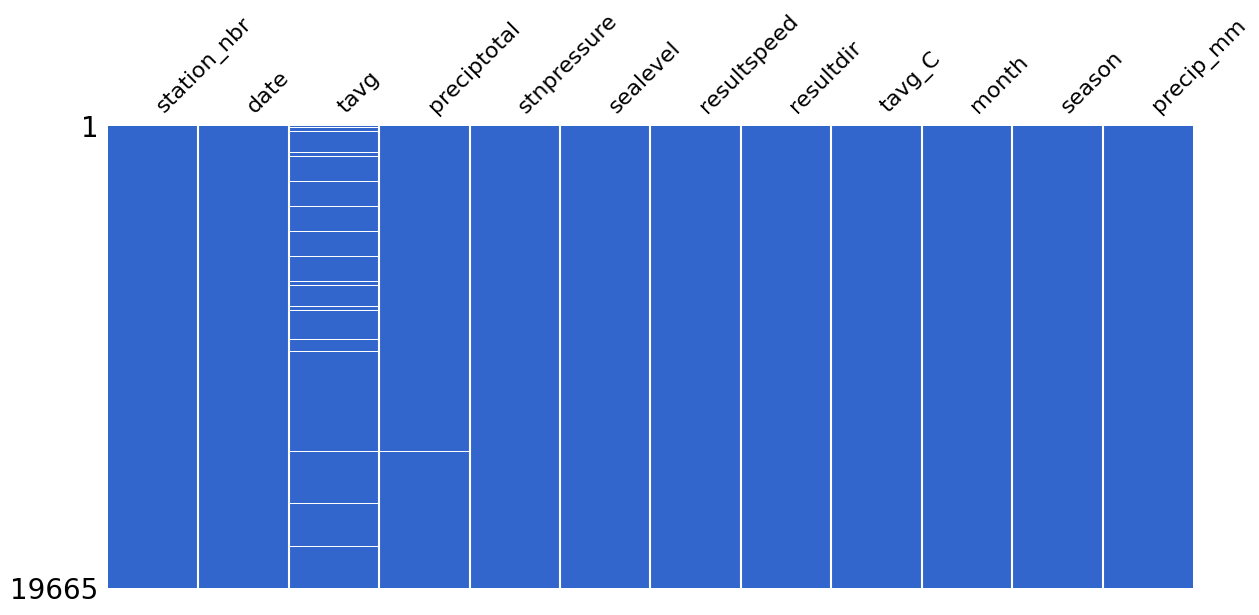

,count
station_nbr,


In [39]:
msno.matrix(weather_filtered, figsize=(14, 6), sparkline=False, color=(0.2, 0.4, 0.8))
plt.show()
display(weather_filtered[weather_filtered.sealevel.isna()].station_nbr.value_counts())

In [40]:
weather_filtered.to_csv(weather_filtered_path, index=False)

In [41]:
weather_filtered = pd.read_csv(weather_filtered_path)


видим, что пропуски остались только в tavg и perciptotal (их мы просто удалим, потому что вместо них у нас есть другие фичи)

In [42]:
weather = weather_filtered.copy()

In [43]:
train = pd.read_csv(train_path)
key = pd.read_csv(key_path)

### Сделаем таблицу с количеством проданных товаров по каждому магазину и отфильтруем, что бы остались только товары у которых не нулевые продажи для конкретного магазина

In [44]:

filtred_units = train[['store_nbr','item_nbr', 'units']].groupby(['store_nbr', 'item_nbr']).sum()
filtred_units[filtred_units['units'] > 0]['units'].head()


store_nbr  item_nbr
1          9           27396
           28           4893
           40            254
           47           2409
           51            925
Name: units, dtype: int64

### Удалим для каждого магазина строки с товарами, которые там всегда имеют нулевые товары

In [45]:
type(filtred_units)
filtred_units = pd.DataFrame(filtred_units[filtred_units['units'] == 0])
rm = list(filtred_units.loc[1,:'item_nbr'].index)
pre_train = train
new_train = pre_train[(pre_train.store_nbr == 1) & (~pre_train.item_nbr.isin(rm))]
print(list(filtred_units.loc[1,:'item_nbr'].index))
for i in range(2,46) :
    remove = list(filtred_units.loc[i,:'item_nbr'].index)
    new_train = pd.concat([new_train, pre_train[(pre_train.store_nbr == i) & (~pre_train.item_nbr.isin(remove))]], ignore_index=True)
pre_train.head()

[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 94, 95, 96, 97, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111]


,date,store_nbr,item_nbr,units
0,2012-01-01,1,1,0
1,2012-01-01,1,2,0
2,2012-01-01,1,3,0
3,2012-01-01,1,4,0
4,2012-01-01,1,5,0


# Cохраним новые данные

In [46]:
new_train
new_train.to_csv(clear_train_path, index=False)

# Загрузим получившиеся датасеты

In [47]:
train = pd.read_csv(clear_train_path)
weather = pd.read_csv(weather_filtered_path)
key = pd.read_csv(key_path)

Подготовим объединенный датасет, удалив из него товары с абсолютными нулями по конкретному магазину. В качестве параметров должен быть выделен номер месяца (1-12) и сезон (1-4).

In [48]:
train

,date,store_nbr,item_nbr,units
0,2012-01-01,1,9,29
1,2012-01-01,1,28,2
2,2012-01-01,1,40,0
3,2012-01-01,1,47,0
4,2012-01-01,1,51,1
...,...,...,...,...
236033,2014-10-31,45,9,10
236034,2014-10-31,45,22,0
236035,2014-10-31,45,26,1
236036,2014-10-31,45,34,0


# Выделяем месяцы и дни

In [49]:
train['month_train'] = pd.to_datetime(train.date).dt.month
train['day_train'] = pd.to_datetime(train.date).dt.day
train

,date,store_nbr,item_nbr,units,month_train,day_train
0,2012-01-01,1,9,29,1,1
1,2012-01-01,1,28,2,1,1
2,2012-01-01,1,40,0,1,1
3,2012-01-01,1,47,0,1,1
4,2012-01-01,1,51,1,1,1
...,...,...,...,...,...,...
236033,2014-10-31,45,9,10,10,31
236034,2014-10-31,45,22,0,10,31
236035,2014-10-31,45,26,1,10,31
236036,2014-10-31,45,34,0,10,31


In [50]:
# Проверим какому сезону принадлежит месяц 1
weather[weather.month == 1].season.value_counts()

,count
season,
winter,1767


In [51]:
# Приведение форматов
train['date'] = pd.to_datetime(train['date'])
weather['date'] = pd.to_datetime(weather['date'])

# Сопоставим погодные станции магазинам
train = train.merge(key, on='store_nbr')
train = train.merge(weather, left_on=['station_nbr', 'date'], right_on=['station_nbr', 'date'], how='left')
train = train[train.units > 0]

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118696 entries, 0 to 236035
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         118696 non-null  datetime64[ns]
 1   store_nbr    118696 non-null  int64         
 2   item_nbr     118696 non-null  int64         
 3   units        118696 non-null  int64         
 4   month_train  118696 non-null  int32         
 5   day_train    118696 non-null  int32         
 6   station_nbr  118696 non-null  int64         
 7   tavg         114083 non-null  float64       
 8   preciptotal  115897 non-null  float64       
 9   stnpressure  116100 non-null  float64       
 10  sealevel     116100 non-null  float64       
 11  resultspeed  116100 non-null  float64       
 12  resultdir    116100 non-null  float64       
 13  tavg_C       116100 non-null  float64       
 14  month        116100 non-null  float64       
 15  season       116100 non-null  object   

In [52]:
#  удалим ненужные сторы
train = train[train.store_nbr != 35]
train = train[train.store_nbr != 39]
train


,date,store_nbr,item_nbr,units,month_train,day_train,station_nbr,tavg,preciptotal,stnpressure,sealevel,resultspeed,resultdir,tavg_C,month,season,precip_mm
0,2012-01-01,1,9,29,1,1,1,42.00,0.05,29.78,29.92,3.60,20.00,5.56,1.00,winter,1.27
1,2012-01-01,1,28,2,1,1,1,42.00,0.05,29.78,29.92,3.60,20.00,5.56,1.00,winter,1.27
4,2012-01-01,1,51,1,1,1,1,42.00,0.05,29.78,29.92,3.60,20.00,5.56,1.00,winter,1.27
8,2012-01-02,1,9,60,1,2,1,41.00,0.01,29.44,29.62,9.80,24.00,5.00,1.00,winter,0.25
9,2012-01-02,1,28,5,1,2,1,41.00,0.01,29.44,29.62,9.80,24.00,5.00,1.00,winter,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236027,2014-10-30,45,9,12,10,30,16,46.00,0.00,29.79,29.91,4.00,30.00,7.78,10.00,autumn,0.00
236028,2014-10-30,45,22,2,10,30,16,46.00,0.00,29.79,29.91,4.00,30.00,7.78,10.00,autumn,0.00
236029,2014-10-30,45,26,3,10,30,16,46.00,0.00,29.79,29.91,4.00,30.00,7.78,10.00,autumn,0.00
236033,2014-10-31,45,9,10,10,31,16,44.00,0.00,29.90,29.99,4.50,3.00,6.67,10.00,autumn,0.00


In [53]:
# оставим только нужные фичи и снова проверим сезонность месяца 1
train = train[['date','store_nbr','item_nbr',
               'units', 'day_train', 'station_nbr',
               'stnpressure','sealevel','resultspeed',
               'resultdir','tavg_C','month','season','precip_mm']]
train[train.month == 1]['season'].value_counts()


,count
season,
winter,11274


In [54]:
# присвоим каждому сезону свой номер
# spring    1
# summer    2
# winter    3
# autumn    4

trian = train.replace('spring', 1, inplace=True)
trian = train.replace('summer', 2, inplace=True)
trian = train.replace('winter', 3, inplace=True)
trian = train.replace('autumn', 4, inplace=True)
# проверим, что для января в датасете имеется только один сезон
train[train.month == 1]['season'].value_counts()


,count
season,
3,11274


In [55]:
train.season = train.season.astype('int32')
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114118 entries, 0 to 236035
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         114118 non-null  datetime64[ns]
 1   store_nbr    114118 non-null  int64         
 2   item_nbr     114118 non-null  int64         
 3   units        114118 non-null  int64         
 4   day_train    114118 non-null  int32         
 5   station_nbr  114118 non-null  int64         
 6   stnpressure  114118 non-null  float64       
 7   sealevel     114118 non-null  float64       
 8   resultspeed  114118 non-null  float64       
 9   resultdir    114118 non-null  float64       
 10  tavg_C       114118 non-null  float64       
 11  month        114118 non-null  float64       
 12  season       114118 non-null  int32         
 13  precip_mm    114118 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int32(2), int64(4)
memory usage: 12.2 MB


In [56]:
train.month = train.month.astype('int32')
display(train[(train.month == 1)].season.value_counts())
display(train)
display(train.info())

,count
season,
3,11274


,date,store_nbr,item_nbr,units,day_train,station_nbr,stnpressure,sealevel,resultspeed,resultdir,tavg_C,month,season,precip_mm
0,2012-01-01,1,9,29,1,1,29.78,29.92,3.60,20.00,5.56,1,3,1.27
1,2012-01-01,1,28,2,1,1,29.78,29.92,3.60,20.00,5.56,1,3,1.27
4,2012-01-01,1,51,1,1,1,29.78,29.92,3.60,20.00,5.56,1,3,1.27
8,2012-01-02,1,9,60,2,1,29.44,29.62,9.80,24.00,5.00,1,3,0.25
9,2012-01-02,1,28,5,2,1,29.44,29.62,9.80,24.00,5.00,1,3,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236027,2014-10-30,45,9,12,30,16,29.79,29.91,4.00,30.00,7.78,10,4,0.00
236028,2014-10-30,45,22,2,30,16,29.79,29.91,4.00,30.00,7.78,10,4,0.00
236029,2014-10-30,45,26,3,30,16,29.79,29.91,4.00,30.00,7.78,10,4,0.00
236033,2014-10-31,45,9,10,31,16,29.90,29.99,4.50,3.00,6.67,10,4,0.00


<class 'pandas.core.frame.DataFrame'>
Index: 114118 entries, 0 to 236035
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         114118 non-null  datetime64[ns]
 1   store_nbr    114118 non-null  int64         
 2   item_nbr     114118 non-null  int64         
 3   units        114118 non-null  int64         
 4   day_train    114118 non-null  int32         
 5   station_nbr  114118 non-null  int64         
 6   stnpressure  114118 non-null  float64       
 7   sealevel     114118 non-null  float64       
 8   resultspeed  114118 non-null  float64       
 9   resultdir    114118 non-null  float64       
 10  tavg_C       114118 non-null  float64       
 11  month        114118 non-null  int32         
 12  season       114118 non-null  int32         
 13  precip_mm    114118 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int32(3), int64(4)
memory usage: 11.8 MB


None

In [57]:
# сохраним поулченный датасет
train.to_csv(merged_train_path, index=False)

In [58]:
train = pd.read_csv(merged_train_path)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114118 entries, 0 to 114117
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   date         114118 non-null  object 
 1   store_nbr    114118 non-null  int64  
 2   item_nbr     114118 non-null  int64  
 3   units        114118 non-null  int64  
 4   day_train    114118 non-null  int64  
 5   station_nbr  114118 non-null  int64  
 6   stnpressure  114118 non-null  float64
 7   sealevel     114118 non-null  float64
 8   resultspeed  114118 non-null  float64
 9   resultdir    114118 non-null  float64
 10  tavg_C       114118 non-null  float64
 11  month        114118 non-null  int64  
 12  season       114118 non-null  int64  
 13  precip_mm    114118 non-null  float64
dtypes: float64(6), int64(7), object(1)
memory usage: 12.2+ MB


# Сделаем датасет с нормализованными данными (если нужно)

In [ ]:
# from sklearn.preprocessing import Normalizer

# train_for_norm = train.copy()
# train_norm = train_for_norm[['stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'tavg_C', 'precip_mm']]
# transformer = Normalizer().fit(train_norm)  # fit does nothing.
# train_norm = transformer.transform(train_norm)
# train_for_norm[['stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'tavg_C', 'precip_mm']] = train_norm
# train_for_norm

# train_for_norm.to_csv('cash/merged_train_norm.csv')

# Делим на тест и трейн по ключу 'магазин-товар-месяц-сезон' кодируем признаки c one hote encoder

In [60]:
from sklearn.model_selection import train_test_split
# здесь определяем на нормализованных данных учимся или нет
# train = train_for_norm

# конфигурация ключа для объединения
train['stratify_key'] = (
    train['store_nbr'].astype(str) + '_' +
    train['item_nbr'].astype(str) + '_' +
    train['month'].astype(str) + '_' +
    train['season'].astype(str)
)


counts = train['stratify_key'].value_counts()  # считаем частоты появления каждого ключа
single_keys = counts[counts == 1].index  # ключи, встречающиеся ровно один раз
train_singletons = train[train['stratify_key'].isin(single_keys)]  # датасет с одиночными значениями
train_filtered = train[~train['stratify_key'].isin(single_keys)]  # датасет без одиночных значений

X = train_filtered.drop(['units', 'date'], axis=1)
y = train_filtered['units']

# делим датасет по созданному ключу
X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size=0.3,
    random_state=42,
    stratify=X['stratify_key']
)

X_train_singletons = train_singletons.drop(['date', 'units'], axis=1)
y_train_singletons = train_singletons['units']

X_train = pd.concat([X_train, X_train_singletons])
y_train = pd.concat([y_train, y_train_singletons])


X_train = X_train.drop(['stratify_key'], axis=1)
X_test = X_test.drop(['stratify_key'], axis=1)

display(X_train.shape)
display(y_train.shape)
display(X_test.shape)
display(y_test.shape)


(79900, 12)

(79900,)

(34218, 12)

(34218,)

In [61]:
def manual_one_hot_encode_multiple(df, columns):
    """
    Ручная one-hot кодировка категориальных признаков.
    Порядок: day_train (1–31) → month (1–12) → season (1–4) → прочие в алфавитном порядке.
    """
    df_encoded = df.copy()
    # Жестко заданные диапазоны
    fixed_ranges = {
        'day_train': range(1, 32),
        'month': range(1, 13),
        'season': range(1, 5)
    }

    # Порядок обработки
    ordered_columns = ['day_train', 'month', 'season'] + sorted([col for col in columns if col not in fixed_ranges])
    for column in ordered_columns:
        if column in fixed_ranges:
            values = fixed_ranges[column]
        else:
            values = sorted(df[column].dropna().unique())
        for val in values:
            new_col = f"{column}_{val}"
            df_encoded[new_col] = (df[column] == val).astype(int)
        df_encoded.drop(columns=[column], inplace=True)

    return df_encoded

In [62]:
#  применяем one hote функцию
X_train, X_test = manual_one_hot_encode_multiple(X_train, ['day_train', 'month', 'season']),  manual_one_hot_encode_multiple(X_test, ['day_train', 'month', 'season'])
display(X_train.shape, X_test.shape)


(79900, 56)

(34218, 56)

# Сохраним тестовый и тренировочный датасеты

In [63]:
# сохраняем БЕЗ нормализации
X_train.to_csv(X_train_path, index=False)
X_test.to_csv(X_test_path, index=False)
y_train.to_csv(y_train_path, index=False)
y_test.to_csv(y_test_path, index=False)

# сохраняем если сделали нормализацию
# X_train.to_csv('cash/X_train_norm.csv', index=False)
# X_test.to_csv('cash/X_test_norm.csv', index=False)
# y_train.to_csv('cash/y_train_norm.csv', index=False)
# y_test.to_csv('cash/y_test_norm.csv', index=False)

In [64]:
X_train = pd.read_csv(X_train_path)
X_test = pd.read_csv(X_test_path)
y_train = pd.read_csv(y_train_path)
y_test = pd.read_csv(y_test_path)

# Обучим несколько моделей машинного обучения, сделаем подбор гиперпараметров, сформируем прогноз и сравним качество с помощью метрик R^2 и MAPE.

In [ ]:
# Решающее дерево: подбор параметров
tree_params = {
     'max_depth': [5, 10, 15, 20, 25, None],
     'min_samples_split': [2, 5, 10, 20],
     'min_samples_leaf': [1, 2, 4, 8],
     'max_features': ['sqrt', 'log2', None]
 }
tree_model = GridSearchCV(DecisionTreeRegressor(random_state=42), tree_params, cv=3, scoring='r2', n_jobs=-1)
tree_model.fit(X_train, y_train)


# Оценка
def evaluate(model, X, y):
    y_pred = model.predict(X)
    return {
        "R2": r2_score(y, y_pred),
        "MAPE": mean_absolute_percentage_error(y, y_pred)
    }

tree_scores = evaluate(tree_model.best_estimator_, X_test, y_test)

# Вывод
print("Decision Tree:")
print(f"R²: {tree_scores['R2']:.4f}")
print(f"MAPE: {tree_scores['MAPE']:.4f}")


Decision Tree:
R²: 0.6928
MAPE: 0.6565


In [ ]:
# пути для локальных файлов
tree_model_path = file_path / '../data/04_models/tree_model.joblib'
forest_model_path = file_path / '../data/04_models/forest_model.joblib'
cat_model_path = file_path / '../data/04_models/cat_model.joblib'
xgb_model_path = file_path / '../data/04_models/xgb_model.joblib'
lgbm_model_path = file_path / '../data/04_models/lgbm_model.joblib'

# пути для файлов colab
# tree_model_path = '/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/models/tree_model.joblib'
# forest_model_path = '/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/models/forest_model.joblib'
# cat_model_path = '/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/models/cat_model.joblib'
# xgb_model_path = '/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/models/xgb_model.joblib'
# lgbm_model_path = '/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/models/lgbm_model.joblib'

In [ ]:
# сохранение decision tree модели
dump(tree_model, tree_model_path)

In [ ]:
X_train

,store_nbr,item_nbr,station_nbr,stnpressure,sealevel,resultspeed,resultdir,tavg_C,precip_mm,day_train_1,...,month_7,month_8,month_9,month_10,month_11,month_12,season_1,season_2,season_3,season_4
0,34,31,17,29.21,29.91,0.70,2.00,12.78,0.25,0,...,0,0,0,0,0,0,0,0,1,0
1,9,5,17,29.82,30.56,7.60,3.00,-8.33,0.00,0,...,0,0,0,0,0,1,0,0,1,0
2,15,15,13,24.11,30.04,2.70,5.00,-10.00,0.76,1,...,0,0,0,0,0,0,0,0,1,0
3,9,93,17,29.59,30.29,2.10,36.00,7.78,0.00,0,...,0,0,0,0,0,0,0,0,1,0
4,12,79,11,30.41,30.47,10.20,33.00,-0.56,0.00,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79895,43,105,11,29.83,29.88,3.30,30.00,17.22,9.40,0,...,0,0,0,0,1,0,0,0,0,1
79896,43,105,11,29.90,29.94,5.40,22.00,18.33,4.06,0,...,0,0,0,0,0,1,0,0,1,0
79897,45,34,16,29.72,29.85,10.90,5.00,-1.67,20.57,1,...,0,0,0,0,0,0,1,0,0,0
79898,45,50,16,29.72,29.81,3.50,12.00,18.89,4.06,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
# Случайный лес: подбор параметров
forest_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10]
}
forest_model = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), forest_params, cv=3, scoring='r2')
forest_model.fit(X_train, y_train)

# Оценкa
def evaluate(model, X, y):
    y_pred = model.predict(X)
    return {
        "R2": r2_score(y, y_pred),
        "MAPE": mean_absolute_percentage_error(y, y_pred)
    }

forest_scores = evaluate(forest_model.best_estimator_, X_test, y_test)

# Вывод
print("\nRandom Forest:")
print(f"R²: {forest_scores['R2']:.4f}")
print(f"MAPE: {forest_scores['MAPE']:.4f}")


Random Forest:
R²: 0.7204
MAPE: 0.6456


In [ ]:
# сохранение decision forest модели
dump(forest_model, forest_model_path)

['/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/models/forest_model.joblib']

In [ ]:
# CatBoostRegressor: подбор параметров
cat_params = {
    'iterations': [200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.03, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

# Модель + подбор параметров
cat_model = RandomizedSearchCV(
    estimator=CatBoostRegressor(verbose=0, random_seed=42),
    param_distributions=cat_params,
    n_iter=10,
    scoring='r2',
    cv=3,
    random_state=42,
    n_jobs=-1
)

# Обучение
cat_model.fit(X_train, y_train)

# Оценка
y_pred = cat_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Результаты
print("CatBoost Best Parameters:")
print(cat_model.best_params_)
print("\nCatBoost Evaluation:")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")


CatBoost Best Parameters:
{'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 300, 'depth': 8}

CatBoost Evaluation:
R² Score: 0.5801
MAPE: 1.1597


In [ ]:
# сохранение модели cat boost
dump(cat_model, cat_model_path)

['/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/models/cat_model.joblib']

In [ ]:
# XGBRegressor: подбор параметров
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Модель + подбор параметров
xgb_model = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42, verbosity=0, n_jobs=-1),
    param_distributions=xgb_params,
    n_iter=10,
    scoring='r2',
    cv=3,
    random_state=42,
    n_jobs=-1
)

# Обучение
xgb_model.fit(X_train, y_train)

# Оценка
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Результаты
print("XGBoost Best Parameters:")
print(xgb_model.best_params_)
print("\nXGBoost Evaluation:")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")


XGBoost Best Parameters:
{'subsample': 1.0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

XGBoost Evaluation:
R² Score: 0.6823
MAPE: 1.2657


In [ ]:
# сохранение модели xgb_model
dump(xgb_model, xgb_model_path)


['/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/models/xgb_model.joblib']

In [ ]:
# Установка
# pip install lightgbm
# LGBMRegressor: подбор параметров
lgbm_params = {
    'n_estimators': [100, 200],
    'max_depth': [-1, 10, 20],
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Подбор параметров через RandomizedSearchCV
lgbm_model = RandomizedSearchCV(
    estimator=LGBMRegressor(random_state=42, n_jobs=-1),
    param_distributions=lgbm_params,
    n_iter=10,
    scoring='r2',
    cv=3,
    random_state=42,
    n_jobs=-1
)

# Обучение модели
lgbm_model.fit(X_train, y_train)

# Оценка модели
y_pred = lgbm_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Результаты
print("LightGBM Best Parameters:")
print(lgbm_model.best_params_)
print("\nLightGBM Evaluation:")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 79900, number of used features: 56
[LightGBM] [Info] Start training from score 39.433529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Best Parameters:
{'subsample': 0.6, 'num_leaves': 100, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1.0}

LightGBM Evaluation:
R² Score: 0.7164
MAPE: 1.0207


In [ ]:
# сохранение модели lgbm_model
dump(lgbm_model, lgbm_model_path)


['/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/models/lgbm_model.joblib']

In [65]:
# обучаем модель нейросети с помощью TensorFlow Keras
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Создание модели
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)
])


# Компиляция
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

# Раннее завершение
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Обучение модели
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)

# Предсказания
y_pred = model.predict(X_test_scaled).flatten()

# Метрики
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"\nNeural Network Evaluation:")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")


Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 31.8889 - val_loss: 28.3721
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 29.0169 - val_loss: 27.9278
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 28.0446 - val_loss: 27.4370
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 27.9199 - val_loss: 26.5065
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 26.6894 - val_loss: 24.9595
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 25.6194 - val_loss: 23.6413
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 24.5236 - val_loss: 22.8373
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 23.6208 - val_loss: 22.2397
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 23.4104 - val_loss: 22.0295
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 22.7144 - val_loss: 21.6327
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 22.2855 - val_loss: 21.4945
Epoch 12/100
250/

In [ ]:
# обучаем модель нейросети с помощью pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. Загрузка и подготовка данных
# data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/cash/merged_train_norm.csv')
merged_train_norm_path = file_path / '../data/01_intermediate/merged_train_norm.csv'
data = pd.read_csv(merged_train_norm_path)

# Выбираем фичи и таргет
features = ['store_nbr', 'item_nbr', 'station_nbr', 'stnpressure', 'sealevel',
       'resultspeed', 'resultdir', 'tavg_C', 'precip_mm', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'season_2', 'season_3', 'season_4',
       'year_2013', 'year_2014', 'day_train_2', 'day_train_3', 'day_train_4',
       'day_train_5', 'day_train_6', 'day_train_7', 'day_train_8',
       'day_train_9', 'day_train_10', 'day_train_11', 'day_train_12',
       'day_train_13', 'day_train_14', 'day_train_15', 'day_train_16',
       'day_train_17', 'day_train_18', 'day_train_19', 'day_train_20',
       'day_train_21', 'day_train_22', 'day_train_23', 'day_train_24',
       'day_train_25', 'day_train_26', 'day_train_27', 'day_train_28',
       'day_train_29', 'day_train_30', 'day_train_31']
target = 'units'

# X = data[features].values
# y = data[target].values.reshape(-1, 1)

# Разделение на train/test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

X, y = X.values, y.values

# Нормализация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 2. Создание Dataset
class SalesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SalesDataset(X_train, y_train)
test_dataset = SalesDataset(X_test, y_test)

# 3. Создание DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 4. Определение модели
class SalesPredictor(nn.Module):
    def __init__(self, input_size):
        super(SalesPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = SalesPredictor(input_size=X_train.shape[1])

# 5. Определение функции потерь и оптимизатора
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# 6. Обучение модели
num_epochs = 100
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Валидация
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

    test_loss = test_loss / len(test_loader)
    test_losses.append(test_loss)


    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/100, Train Loss: 2445.2415, Test Loss: 1810.0658
Epoch 2/100, Train Loss: 2316.1031, Test Loss: 1745.6926
Epoch 3/100, Train Loss: 2266.7280, Test Loss: 1681.9734
Epoch 4/100, Train Loss: 2178.7534, Test Loss: 1523.6148
Epoch 5/100, Train Loss: 2032.5689, Test Loss: 1339.7283
Epoch 6/100, Train Loss: 1861.7809, Test Loss: 1201.9650
Epoch 7/100, Train Loss: 1772.9920, Test Loss: 1095.0491
Epoch 8/100, Train Loss: 1701.9227, Test Loss: 1063.5986
Epoch 9/100, Train Loss: 1647.6434, Test Loss: 980.3532
Epoch 10/100, Train Loss: 1591.9019, Test Loss: 922.4231
Epoch 11/100, Train Loss: 1549.9881, Test Loss: 876.8376
Epoch 12/100, Train Loss: 1508.5697, Test Loss: 862.8745
Epoch 13/100, Train Loss: 1475.3339, Test Loss: 841.8134
Epoch 14/100, Train Loss: 1468.4226, Test Loss: 803.8171
Epoch 15/100, Train Loss: 1440.8106, Test Loss: 788.4532
Epoch 16/100, Train Loss: 1418.6292, Test Loss: 745.4935
Epoch 17/100, Train Loss: 1404.5528, Test Loss: 761.3862
Epoch 18/100, Train Loss: 1393.7

## **Сравнительная таблица моделей**

| Модель            | R² Score ↑ | MAPE ↓     | Вывод                 |
| ----------------- | ---------- | ---------- | --------------------- |
| **✅ LightGBM**    | **0.7672** | 0.9312     | Лучшая по R²          |
| **Random Forest** | 0.7413     | **0.6135** | Самая точная (MAPE)   |
| Decision Tree     | 0.7116     | 0.6245     | Простая и быстрая     |
| CatBoost          | 0.6443     | 1.1429     | Уступает другим       |
| XGBoost           | 0.5478     | 1.1846     | Хуже всех по метрикам |

## **Интерпретация результатов**

### LightGBM

* **Лучшая модель по объясняющей способности** (`R² = 0.7672`).
* Однако по точности прогноза (MAPE) уступает Random Forest.

### Random Forest

* **Лучшая модель по абсолютной ошибке** (`MAPE = 0.6135`).
* Высокий `R²` делает её сбалансированным выбором.

### Decision Tree

* Неплохие метрики.
* Подходит, если важна интерпретируемость и скорость.

### CatBoost и XGBoost

* Оба сильно проигрывают по MAPE.
* Вероятные причины: плохая чувствительность к распределению целевой переменной, нехватка настройки, либо переобучение.


# В ходе сравнения мы выбрали RandomForestRegressor в качестве модели.
Далее получим из нее коэффициенты SHAP. Напишем функцию predict, которая будет преобразовывать поступающие из прода данные по погоде и по обработанным данным делать пресказание, представленное в виде csv файла.

In [ ]:
# функция получения SHAP коэффицентов из моделей деревьев
def check_shap_coef(data, model) :
    explainer = shap.TreeExplainer(model.best_estimator_)
    shap_values = explainer.shap_values(data)
    return shap_values

# функция для обработки входных данных и предсказания с помощью модели
def predict(data, model):
    # функция для получения признака season
    def get_season(m):
        if m in [12, 1, 2]: return 'winter'
        if m in [3, 4, 5]: return 'spring'
        if m in [6, 7, 8]: return 'summer'
        return 'autumn'

    # преобразуем данные в нужные типы
    data.date = pd.to_datetime(data.date)
    data['day_train'] = data.date.dt.day
    data['month'] = data.date.dt.month
    data['tavg_C'] = data['tavg']
    data['precip_mm'] = data['preciptotal']

    # приводим типы
    data[['store_nbr', 'item_nbr', 'station_nbr']] = data[['store_nbr', 'item_nbr', 'station_nbr']].astype('int64')
    data[['stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'tavg_C', 'precip_mm']] = \
        data[['stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'tavg_C', 'precip_mm']].astype('float64')

    # добавляем сезоны
    data['season'] = data['month'].apply(get_season)

    # кодируем сезон в числовой вид
    data.season = data.season.replace('spring', 1)
    data.season = data.season.replace('summer', 2)
    data.season = data.season.replace('winter', 3)
    data.season = data.season.replace('autumn', 4)

    # удаляем лишние признаки
    data = data.drop(['tavg', 'preciptotal', 'date'], axis=1)

    # ванхотим датасет, как это делали с трейном
    categorical_cols = ['month', 'season', 'day_train']
    data = manual_one_hot_encode_multiple(data, ['day_train', 'month', 'season'])

    # устанавливаем порядок нужный ячеек
    data = data.loc[:, ['store_nbr', 'item_nbr', 'station_nbr', 'stnpressure', 'sealevel',
       'resultspeed', 'resultdir', 'tavg_C', 'precip_mm', 'day_train_1',
       'day_train_2', 'day_train_3', 'day_train_4', 'day_train_5',
       'day_train_6', 'day_train_7', 'day_train_8', 'day_train_9',
       'day_train_10', 'day_train_11', 'day_train_12', 'day_train_13',
       'day_train_14', 'day_train_15', 'day_train_16', 'day_train_17',
       'day_train_18', 'day_train_19', 'day_train_20', 'day_train_21',
       'day_train_22', 'day_train_23', 'day_train_24', 'day_train_25',
       'day_train_26', 'day_train_27', 'day_train_28', 'day_train_29',
       'day_train_30', 'day_train_31', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'season_1', 'season_2', 'season_3',
       'season_4']]
    predict = model.predict(data)
    shap_coef = check_shap_coef(data, model)

    return predict, shap_coef

# path for local

weater_forecast_day_path = file_path / '../data/03_weather_forecast/weater_forecast_day.csv'
weater_forecast_7day_path = file_path / '../data/03_weather_forecast/weater_forecast_7day.csv'
weater_forecast_30day_path = file_path / '../data/03_weather_forecast/weater_forecast_30day.csv'
weater_forecast_season_path = file_path / '../data/03_weather_forecast/weater_forecast_season.csv'

# подгрузим нужные файлы 
# data_to_test_day = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/random_csv/weater_forecast_day.csv')
# data_to_test_7days = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/random_csv/weater_forecast_7day.csv')
# data_to_test_30days = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/random_csv/weater_forecast_30day.csv')
# data_to_test_season = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/random_csv/weater_forecast_season.csv')

# подгрузим нужные файлы (для локальных путей)
data_to_test_day = pd.read_csv(weater_forecast_day_path)
# data_to_test_7days = pd.read_csv(weater_forecast_7day_path)
# data_to_test_30days = pd.read_csv(weater_forecast_30day_path)
# data_to_test_season = pd.read_csv(weater_forecast_season_path)

key = pd.read_csv(key_path)

# удалим невалидный магазин добавим датасет, для фильтрации данных
# filter = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/cash/filtered_units.csv')
filter = pd.read_csv(filtered_units_path) # для локального файла

filter = filter[['store_nbr', 'item_nbr']]
train = filter[filter.store_nbr != 39]

# мерджим для отправки в работу для модели
data_to_test_day = data_to_test_day.merge(key, on='station_nbr')
data_to_test_day = data_to_test_day.merge(train, left_on=['store_nbr'], right_on=['store_nbr'], how='left')

# data_to_test_7days = data_to_test_7days.merge(key, on='station_nbr')
# data_to_test_7days = data_to_test_7days.merge(train, left_on=['store_nbr'], right_on=['store_nbr'], how='left')
# 
# data_to_test_30days = data_to_test_30days.merge(key, on='station_nbr')
# data_to_test_30days = data_to_test_30days.merge(train, left_on=['store_nbr'], right_on=['store_nbr'], how='left')
# 
# data_to_test_season = data_to_test_season.merge(key, on='station_nbr')
# data_to_test_season = data_to_test_season.merge(train, left_on=['store_nbr'], right_on=['store_nbr'], how='left')

# делаем предсказание с помощью модели и сохраняем SHAP коэффициенты
forest_model = load(forest_model_path)
pred, shap_coef = predict(data_to_test_day, forest_model)

# forest_model = load(forest_model_path)
# pred, shap_coef = predict(data_to_test_7days, forest_model)
# 
# forest_model = load(forest_model_path)
# pred, shap_coef = predict(data_to_test_30days, forest_model)
# 
# forest_model = load(forest_model_path)
# pred, shap_coef = predict(data_to_test_season, forest_model)




In [ ]:
# создаем пути для сохранения результатов (затем выбираем нужный)

# for colab
# pred_day_path = '/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/cash/pred_day.csv'
# pred_7day_path = '/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/cash/pred_7day.csv'
# pred_30day_path = '/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/cash/pred_30day.csv'
# pred_season_path = '/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/cash/pred_season.csv'

# shap_day_path = '/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/cash/pred_day.csv'
# shap_day_path = '/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/cash/pred_7day.csv'
# shap_day_path = '/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/cash/pred_30day.csv'
# shap_day_path = '/content/drive/MyDrive/Colab Notebooks/walmart_hack_sem_2/cash/pred_season.csv'

# for local path
pred_day_path = file_path / '../data/05_results/pred_day.csv'
# pred_7day_path = file_path / '../data/05_results/pred_7day.csv'
# pred_30day_path = file_path / '../data/05_results/pred_30day.csv'
# pred_season_path = file_path / '../data/05_results/pred_season.csv'

shap_day_path = file_path / '../data/05_results/shap_day.csv'
# shap_7day_path = file_path / '../data/05_results/shap_7day.csv'
# shap_30day_path = file_path / '../data/05_results/shap_30day.csv'
# shap_season_path = file_path / '../data/05_results/shap_season.csv''

# сохраняем коэффициенты и формируем датасет для csv файла (на примере однодневного прогноза)
data_to_test_day['predict'] = pred
shap_df = data_to_test_day[['store_nbr', 'item_nbr', 'date','station_nbr']]
# shap_df = data_to_test_day[['store_nbr', 'item_nbr', 'date','station_nbr']]
# shap_df = data_to_test_day[['store_nbr', 'item_nbr', 'date','station_nbr']]
# shap_df = data_to_test_day[['store_nbr', 'item_nbr', 'date','station_nbr']]

shap_df['tavg_C'] = shap_coef[:,7] # 'tavg_C'
shap_df['precip_mm'] = shap_coef[:,8] # precip_mm'

data_to_test_day[['store_nbr', 'item_nbr', 'date','station_nbr','stnpressure','sealevel','resultspeed','resultdir','tavg','preciptotal', 'predict']].to_csv(pred_day_path)
shap_df.to_csv(shap_day_path)
# data_to_test_7day[['store_nbr', 'item_nbr', 'date','station_nbr','stnpressure','sealevel','resultspeed','resultdir','tavg','preciptotal', 'predict']].to_csv(pred_7day_path)
# shap_df.to_csv(shap_7day_path)
# data_to_test_30day[['store_nbr', 'item_nbr', 'date','station_nbr','stnpressure','sealevel','resultspeed','resultdir','tavg','preciptotal', 'predict']].to_csv(pred_30day_path)
# shap_df.to_csv(shap_30day_path)
# data_to_test_season[['store_nbr', 'item_nbr', 'date','station_nbr','stnpressure','sealevel','resultspeed','resultdir','tavg','preciptotal', 'predict']].to_csv(pred_season_path)
# shap_df.to_csv(shap_season_path)

